This notebook synthesizes everything into a complete, professional forecasting pipeline.

**Workflow Stages:**
1.  **Data Ingestion:** Handling real-world data (and structural breaks).
2.  **Ensemble Modeling:** Combining methods (ETS + ARIMA + Theta) to improve robustness.
3.  **rigorous Benchmarking:** Using Temporal Cross-Validation to select the best model.
4.  **Business Output:** Translating accuracy metrics into financial impact.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA, AutoETS, Theta, SeasonalNaive

## 1. Data Ingestion: The "Remote Work" Case Study

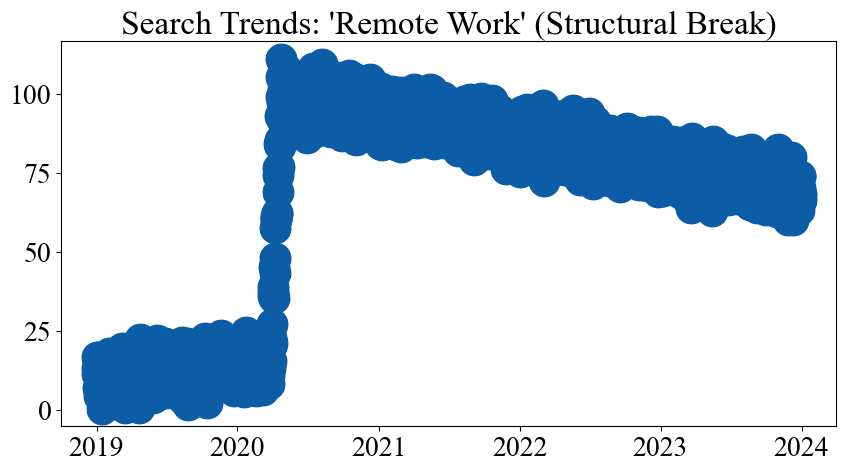

In [4]:
# Note: The book uses pytrends, but we will generate a synthetic replica here to ensure this notebook runs reliably without API blocking issues.
dates = pd.date_range('2019-01-01', '2023-12-31', freq='D')
n = len(dates)
np.random.seed(42)

# 1. Pre-COVID (Flat/Low interest)
# 2. COVID Shock (Massive spike)
# 3. New Normal (Slightly decaying but high)
trend = np.concatenate([
    np.linspace(10, 15, 450),       # Pre-2020-03
    np.linspace(15, 100, 30),       # The Spike (March 2020)
    np.linspace(100, 70, n - 480)   # The New Normal
])
seasonality = 5 * np.sin(2 * np.pi * np.arange(n) / 7) # Weekly pattern
noise = np.random.normal(0, 3, n)

df = pd.DataFrame({
    'unique_id': 'remote_work',
    'ds': dates,
    'y': trend + seasonality + noise
})

plt.figure(figsize=(10, 5))
plt.plot(df['ds'], df['y'])
plt.title("Search Trends: 'Remote Work' (Structural Break)")
plt.show()

## 2. Ensemble Modeling

In [12]:
# %%
# Define the ensemble models
models = [
    AutoETS(season_length=7),
    AutoARIMA(season_length=7),
    Theta(season_length=7)
]

# Initialize StatsForecast
sf = StatsForecast(models=models, freq='D', n_jobs=-1)

# Filter for post-shock data
train_df = df[df['ds'] > '2020-07-01']

# Fit the models
sf.fit(train_df)

# Predict 30 days ahead with 90% confidence intervals
forecasts = sf.predict(h=30, level=[90])

# Calculate the Ensemble Average
forecasts['Ensemble'] = forecasts[['AutoETS', 'AutoARIMA', 'Theta']].mean(axis=1)

# We average the lower and upper bounds of the constituents
forecasts['Ensemble-lo-90'] = forecasts[['AutoETS-lo-90', 'AutoARIMA-lo-90', 'Theta-lo-90']].mean(axis=1)
forecasts['Ensemble-hi-90'] = forecasts[['AutoETS-hi-90', 'AutoARIMA-hi-90', 'Theta-hi-90']].mean(axis=1)

print(forecasts.head())

# Plot the ensemble
sf.plot(train_df, forecasts, level=[90], max_insample_length=90)
plt.show()

     unique_id         ds    AutoETS  AutoETS-lo-90  AutoETS-hi-90  AutoARIMA  \
0  remote_work 2024-01-01  65.786332      60.832900      70.739765  65.596139   
1  remote_work 2024-01-02  69.949780      64.995412      74.904148  70.056981   
2  remote_work 2024-01-03  73.272148      68.316830      78.227467  74.483886   
3  remote_work 2024-01-04  74.303103      69.346819      79.259388  74.551762   
4  remote_work 2024-01-05  71.855602      66.898337      76.812867  72.214491   

   AutoARIMA-lo-90  AutoARIMA-hi-90      Theta  Theta-lo-90  Theta-hi-90  \
0        60.547761        70.644517  66.217773    61.823922    71.759817   
1        65.008228        75.105734  69.612625    64.291065    73.983785   
2        69.435132        79.532639  72.523791    65.885188    77.604174   
3        69.503009        79.600516  73.373465    67.795558    77.970160   
4        67.165738        77.263245  71.329365    66.767909    76.897385   

    Ensemble  Ensemble-lo-90  Ensemble-hi-90  
0  65.866

## 3. The Validation Workflow (Benchmarking)

In [13]:
# Resample to Monthly for the Benchmarking Example
df_monthly = df.set_index('ds').resample('ME')['y'].sum().reset_index()
df_monthly['unique_id'] = 'remote_work_monthly'

# Define candidate models for the benchmark
benchmark_models = [
    SeasonalNaive(season_length=12),  # Baseline
    AutoETS(season_length=12),
    AutoARIMA(season_length=12),
    Theta(season_length=12)
]

# Initialize StatsForecast for Monthly data
sf_benchmark = StatsForecast(
    models=benchmark_models,
    freq='ME', # Month End
    n_jobs=-1
)

### Temporal Cross-Validation

In [14]:
# We simulate retraining the model annually (step_size=12) to forecast the next year (h=12).

# Execute temporal cross-validation
crossvalidation_df = sf_benchmark.cross_validation(
    df=df_monthly,
    h=12,         # Forecast 12 months ahead
    step_size=12, # Retrain annually
    n_windows=2   # Reduced windows for this small synthetic dataset
)

print(crossvalidation_df.head())

             unique_id         ds     cutoff            y  SeasonalNaive  \
0  remote_work_monthly 2022-01-31 2021-12-31  2677.927316    2899.757314   
1  remote_work_monthly 2022-02-28 2021-12-31  2387.325848    2637.171367   
2  remote_work_monthly 2022-03-31 2021-12-31  2643.325657    2881.493532   
3  remote_work_monthly 2022-04-30 2021-12-31  2507.255717    2780.237628   
4  remote_work_monthly 2022-05-31 2021-12-31  2585.569375    2841.452064   

       AutoETS    AutoARIMA        Theta  
0  2704.245878  2788.966568  2752.765487  
1  2704.245878  2788.966568  2801.583837  
2  2704.245878  2788.966568  2850.402187  
3  2704.245878  2788.966568  2899.220537  
4  2704.245878  2788.966568  2948.038887  


## 4. Business Impact & Decision

In [15]:
# Calculate MAE for each model
def mae(y, y_hat):
    return np.mean(np.abs(y - y_hat))

metrics = pd.DataFrame()
model_names = ['SeasonalNaive', 'AutoETS', 'AutoARIMA', 'Theta']

for model in model_names:
    model_mae = mae(crossvalidation_df['y'], crossvalidation_df[model])
    metrics.loc[model, 'MAE'] = model_mae

# Sort by accuracy
metrics = metrics.sort_values('MAE')
best_model_name = metrics.index[0]
best_model_mae = metrics.iloc[0, 0]
baseline_mae = metrics.loc['SeasonalNaive', 'MAE']

print("--- Model Performance (MAE) ---")
print(metrics)

--- Model Performance (MAE) ---
                      MAE
AutoETS        208.103483
SeasonalNaive  251.981988
AutoARIMA      270.769351
Theta          459.848155


In [16]:
# Assumption: Each unit of error costs $1,000 (e.g., lost inventory or wasted ad spend)
cost_per_unit_error = 1000

savings = (baseline_mae - best_model_mae) * cost_per_unit_error

print(f"\n--- Business Impact ---")
print(f"Chosen Model: {best_model_name}")
print(f"Projected Annual Savings vs Baseline: ${savings:,.0f}")


--- Business Impact ---
Chosen Model: AutoETS
Projected Annual Savings vs Baseline: $43,879


## Summary

We have successfully:
1.  Loaded data and handled a regime change.
2.  Built an ensemble to reduce risk.
3.  Ran a temporal cross-validation to honestly benchmark performance.
4.  Translated the technical MAE into a dollar value for stakeholders.